In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = None

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
# print(y_test)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


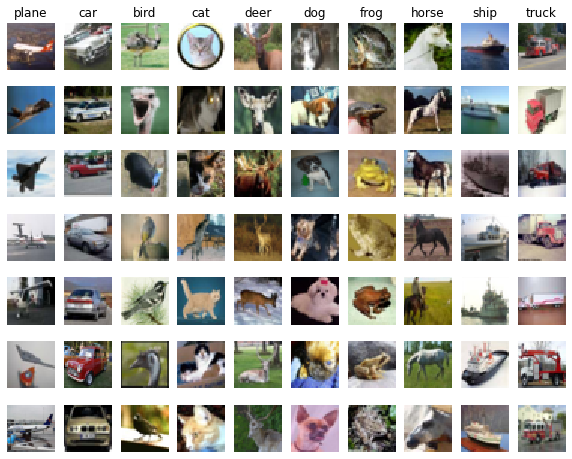

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


(3072,)
[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


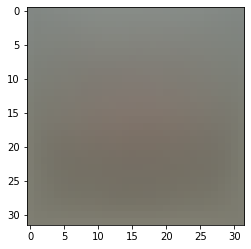

Training data shape:  (49000, 3072)
(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data

print('Training data shape: ', X_train.shape)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))
# print(grad)

loss: 9.238268


In [20]:
# print(grad[100])
# print(grad.shape)
a = np.array([[1,2]])
print(a.shape)
b = np.array([[1,2],[2,4],[0,0]])
print(b.shape)
print(b[0].shape)
print(b[0,:].shape)
print(b[:,0].shape)


(1, 2)
(3, 2)
(2,)
(2,)
(3,)


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print("")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?

loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -1.549415 analytic: -1.549415, relative error: 1.039360e-10
numerical: 17.006938 analytic: 17.006938, relative error: 1.248875e-11
numerical: -4.077583 analytic: -4.077583, relative error: 1.197763e-10
numerical: -4.546213 analytic: -4.546213, relative error: 5.810575e-11
numerical: 17.099402 analytic: 17.099402, relative error: 3.065465e-11
numerical: -9.888931 analytic: -9.888931, relative error: 2.949385e-11
numerical: -5.349419 analytic: -5.349419, relative error: 4.278388e-11
numerical: -1.167883 analytic: -1.079535, relative error: 3.931085e-02
numerical: 19.435242 analytic: 19.435242, relative error: 1.069228e-11
numerical: -10.992341 analytic: -10.992341, relative error: 7.450222e-12

numerical: -4.483130 analytic: -4.483130, relative error: 6.572687e-11
numerical: -4.089907 analytic: -4.089907, relative error: 7.198535e-12
numerical: 22.845459 analytic: 22.845459, relative error: 8.595388e-12
numerical: -28.648742 analytic: -28.648742, relative error: 8.885275e-13
n

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
import time
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.238268e+00 computed in 0.084529s
[[1.21331919 0.49088817 0.99002594 ... 0.         0.77879992 0.89722975]
 [0.78440246 0.91680047 0.17017894 ... 0.58924542 0.73121905 0.66363382]
 [1.0930311  0.         0.90165504 ... 1.11856603 1.23910678 2.03383622]
 ...
 [0.63327038 0.78782379 0.96456894 ... 1.09875254 0.50522258 0.79216655]
 [1.51982055 1.5162746  0.6151782  ... 1.18124336 0.98529113 0.81186209]
 [0.66643171 0.4045959  0.68072522 ... 0.91152107 0.40351282 0.74716303]]
[[1 1 1 ... 0 1 1]
 [1 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[ 1  1  1 ... -9  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1 -9  1 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]]
Vectorized loss: 9.238268e+00 computed in 0.005035s
difference: 0.000000


In [56]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.098736s
Vectorized loss and gradient: computed in 0.001997s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [10]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
import time
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

[44750 30238  7063 32563 41820 42859  8655    19 27722 33063 43220 24719
 48126 22505 19504 42338  4963 43796   583 38592 11443 11754  3559 17879
 37343   167  5396 39219 14968 21891  9610 31862 28528 20508 19216 21751
 45490 27175 37278 11227 31438 40367 31168 47275 48295 38813 48530 45194
 31940 20100 37993 14615 43313 31199  1286 29272 13763 30213 42109  8029
 39745  7113 14393 33994 28316 17348 33351 41638 30330 22508 19358  1956
 21973  3511 22878  5598 34846 26650 15397 14264 15124 40994 19663 13121
 33370 45540  3965 10999 36731 37295 19333 31758 19667 37683 23963  2640
 34013 30294 44221 48021 38746 25511 39994  4019 12785 26499 40353  2332
 12714  2246  6311  8201 39907 17460 15087  8564 27681 23670 38889 34133
 25950 44764 27262  9875 36241  8015 41457 31078 19843 22152 45926 15992
 25569 32325 33365 20348 13498  1518 44064 34350 35983 28432 47509 35326
 46640 36299 15177  4764 42845 40992  7166 10523 12626 31714 47717 43463
 27148  4667 32097 32062 29096 25475 10947 19701  8

 34515  5556 36188 17819    78 31692  4227 44986]
(200, 3073)
[18521 29872 35759 18947 31420 38157  9237 25758 43653 24750 47722 31888
 42881 17443 10174  9178 42078 27646 19232   171 24411 37380 23440 38231
 36363 12262 33453 37480 13555  4998 29484 14385 33069 45295 16194 33034
 16431 14168 44630 10328 34262 43413 32966 33289 29066 16792 27388 11169
  4360 36314  7419 29930 45633 30343 42024 40557 12276 30247  3386  5040
 33266 30048 42342 40081 33679 34940 10220 34457 24877 47180  8994 21758
 17895 36251 24980 30506 10951   113  4005  5622 32470 17051  7183 20461
 31659 18000 14178 14419 30727 41680 27818  1531  8137 36946 44231  8110
 47569 20361  6200 21408 40564 39311 24048 14777 30829  8539  4923 34922
  1245  3250 23189 16397 22769 25034 17456 14269 45313 19357 34410 28693
 10180  4061 40275 45470 44185 45376   626 12274 41319 31002 37181   602
 27474 34755 16177 41335  2700 38855 30563 39154 28845 27595 11744 24098
 17262 32233 29280 21414 40775 46228 34987 13321 46003 32839 2

 28445 29178  9348    25 41840 38005 31727 29124]
(200, 3073)
[ 6074 23900 24355  7965 23280 31872 24542 43931 19045  7839  7163 26288
 31737 43412 42139 33820 44386 36110 38959 39135 45929 12656 12541 35584
 11229 19562 18349 45804 28430 20399 36324  8046 39564 25847 26222 37173
 14682 46335 20903  7078 35638 22846 34284 19687 35666 11783 13998 42673
 26286 33761  8042 20621 19145 44794   820 10158 23018  2994  7109 46539
 10692  3268  2196 47983  1071 29889  8277 23421 25450 42385 17711  2908
 34659 32382 14645 13926  5898 16728 19444 38774 11859  1842 43873 17331
  1600 39313  7663 10230 42006 26934 39485 43033 30034 16883 39539 25845
 35351  1503 18069 22125 34833 33459 40214 15044  8762  8228 33856 16220
 26952 35731 32345 42243 16171 21480 45197  9374 47292 17007 46922 45375
 26039 18507 36227  5801 35539 31660 42786 17090 25220   909  3094 19958
  9892 11610 18114  2522 22335 29593 28209 32001 27620 11946 29907  5242
 12533  3905 28253 32840 38496 17203 44632 26103 11119  9270  

  4683 20136 15028  9318  2638 27029 20565  5011]
(200, 3073)
[23228 17411 34956 16006 31353 39478  5418 36219 20490 20434 28058 12073
 21451  9094 30820 36694 31273 35669 39142 35939 41513  2665 34002 48425
 48208 47017 27391   905 32761  1299  9339 20259  5488 22739 30329 37043
 29322  1828 12112 17725  7859 43195 10077 19898 13227 37417 25127 32966
 21837 39205 20710 42520   410 33263 28040 40322 15187 20701 34694  4493
 23764 43198 45833 34287 17900  7358 16319  1122 46226 45198 28581 48977
 10760 35807 15452 11356 35875  2296 22167 27150 24852 26286 30789 41814
 20577 10444 40939 21088 29501 15852 27044 30827 46084 48368   851 14668
 15777  6378 39453 19124  5787  3321  7738  3339 10859  1643   383 36635
 26986  7848 32314 40702 22198   364  4862 14343 48431 44091  7552   534
 21391 27677 18909 45905  8433 39097 23369  8496 14729  2208 45122 17561
  4755 46531 29307 14348 16330 20711 10552 37507 37390 36841 34947 25437
 29177 32996 37665 31352 21633 41613 27214 11420 12338 35399 2

(200, 3073)
[24721 45857 41229  6530  4914 18661 13144 32406   281 14996 34533 19440
 29473 48451 17065 26970 14044 35997 33652 36374 44808 35252 46359  8851
 14945 18711 26282  1041 32807 16728 37401 43131 46549 16946 21216  8334
 11561 39504 46457  2547 19553  7272 11909 13711  7253 31660 45842 32541
  6519  8661 19156 35252 37299 14102 36534 14722 17496 22518 39169 17937
 24391  7565 42876 20167 14465  5293 28930 25433 24047  5329 40110 42864
 22586 27101  7130 19229 11560 43631 14835 32531 36843 26298 28274 20539
  9072  4003 31917 28456 35338 13268 13127 16200  8146 47769   870 28518
 19338   913 48947 37628 12064 37421 46772 45239 24761 25380 17606 28042
  6347 45529 25771  3075 25682 44040 36882 19219 39620 26488  5813 20075
 13027 45491 29145 38073   889 12932  7006 29277 34060 44310 30915 27162
 22639 36798 34439 13207  4668 10254 46963 13038  7583 45033 27710 13987
  2713 31266 38923 14219 18207 13691 28583 14256 37870  1355 39396  3621
 10723  2625 36300 19030 29549  5674 25

 43111 47422 46216 32347 36474 14325 32167 24633]
(200, 3073)
[38503 31325   967 30431 30991 16969 27575 48390 10197 42495  5813 14472
 12190 21903 17787 47051 25088  1771 47454 23230 15259  9032 37785 46425
  4372 27706 22620  6525 47902 24885  7746  4908 43255 35373 28649 29874
  1708 39691  7403  6224  1895 16712 25276 36424 28208 13412 26356 45046
 34971  3056 13175  5345 36874 15544  5987  9095 31256 41324 48951  9405
  5422 12339 39905 15401 35535 44809 20072 24258 46411 42026 26712 44026
 37160 29636 13776 21182  3698  5829  6577   663  6924 29379  1041 14567
 20059 15111 19053 26913 39339 36902 18204 26787 46567 37282  6513 14347
 21574 11923  1830 13321 32752 26101 10452  8644 39560 41272  3642 46876
 19106  2093 18692 12506 42501 17936 20055 14639  7976 24492  2125 24824
 19905 39208 22900 21341 11464   159 21212 36291 27567 16533 20555 31288
  9695 29558 44934  2465 15650 35730 43886  7163 35271 48452 34209 18410
 31127 15847  3364 18829 35590 28419 27131   765 12921 38013 1

 45387 16166 12287 27360  5741 23762 45933 25211]
(200, 3073)
[10495 10321 29810 41166 27515 10950  5110  5121 33438 23921 42047 41313
 37428  4540 25747   363 41203 24203 27463 40928  1831 37644 10293 20417
 17398 22785  4818 16600  6322 40123 44520 36496 28185 42623 23369  5951
  2406 17216 39078 23111  3616  2645 28429 48692 19619 10731 37427   447
 36609 25730 36221 30897 48235 31428 10403 48431 42512 33505 28762 14634
 30548 20162 47246 35074 32228 18088 26399 16112 41812  1607 32132  3992
  5329 35022 33501 19045 35593 31731 19966 33929 16498 44381 19699  2005
 16316 22674 26566  8065  4048 36586  6172 40252 23466 40788 41632    23
 24127 38655 13585 21453 38428 33890   763 27243 21561 33768 35531 10948
 13616 45397 46220 30704 30756 30346 15724  9228 15116 40088 26147 36555
 20037  6250 46136 18457  6206 19900   739 31737 32549 36733  3872  4330
 15042  2710 22575 32923 40052 33368 41401 16264 48573 38145 32051 35183
  5250  7520 23484 36419 45011 47724  4804 47758 24677 42204 3

 20659 23737 20911 36213 30037 46702  6313 36858]
(200, 3073)
[20508 41883 34770 40784 47286 34605 41373 32561 39734 23390  8209 14369
 10243 17756  6246 27309 38501 24094  6084 28564 33845 32674 23270 19035
 24018 15155 15696 31920 17846 35568 18134 47040  2033 20088 26307 43024
  6666  2071 18894 29502 18621 28090 31633  6894  3170 31265 15602  5442
 25069 23170 46682 33766 43901 45014 16177 45157 20020  1061 39978 36912
 46150 35487 45341 15642 20219 25223  6842  1160 40056   640 10535 36268
 14940 33697 34764 15413 30541 10633 24110 34922 18028 42430 44786 43353
 31446 29236 38159 28168 30614 38430 11601 36815 32917 48375 31241 38953
 10100 17482 29335 10766 23207 46929  5616 18012 15638 20261  6179 10651
 38620 20187 30945  9977 26595  3652 21281 46065 22799 30501 39068 45352
 28022 47997 42574  2250 18801 31750 37938 22574 13189 25683 44007  9715
 32763  9110  1067  1266   675 34773 25573 36794 34695 16124 31737 15723
 33210 43269 36569 35763 34483  5944 28485  1907  6019  7900 4

  4155 47704 16092  4140  9784 40580 12586 15733]
(200, 3073)
[35526   760 16206 41536 32935 27228 19904 17531 13917 14806 17775  5626
  7070 32019 35288 46640  9313  4714 30563  5582 31789 20791 16053  7609
  1530 21013 37501 19854 43524 21546  5089 34663 14593 33117 45016 36539
 17295  2242 44917 41459 41522  7268 34406  9319 46950 20788 31643  3615
 14022 33231 26713 20464  8325 22940 35281 21832 33014 32274 41595 10955
 42087  7122 18929 33677  1196 47450 18382 44603 37881  2667 30994 40927
  1395 46860 48001 30348 35666 48320 32818 19886 30937 18953 17818  4366
 33996 44398 36722 30048 33656   632 41544   249 33516 47063 38979 36541
 48763  3578  5975 24094  6773 14098  1770  2502  6729 38133 29157 38211
  1245 48720   607 11417  7210 21793 25826 38291 36846 10385 19532 20173
 45446 22137 43646 16188 35822 29267 39408 23826 38292 15548 37101 39903
 11165 47104 45065 36477 43897 46913 33710 33088 26563 21223 34682 20866
 14073 22114  6941 12147 20370  6343 19895 11576 41679 14249 4

 37714 23586 39468 30235 32251 36337 41890 28107]
(200, 3073)
[17628 23971 39652 34131 26692 43352 33837 19555 38021  7141 37057 31459
 20248 19915 20843 16950  8447  2212 18490  7558 19227  4391  4323  3374
 11914 35852 47245 31224   191 35049 34630  3282 24244 17985 24434 28712
 47647 39610 35927 37810 24242  8336 26265 28819 25233 40019  4825 41927
 35723 34221 27919 47368  5785 36862 47150   881 42239 18895  5568 33790
 48162 33934 12223 32538   545 14792 24091 36947 13889  8959 22538  1832
  2458 16588  1808 23125 40141 34927  2063 28615 16147 43203  9155 11765
 28798 14072  5451 23352 31506 37422 11763 36502 14317 42428 37554 15339
 36594 31174 35150 19885  3055 43182 30930 35241 42533 28842 22694 41110
  4576 15805 12465 48572  3661 21303 21445 37673 42405 28514 40606 24000
  5499 24143  8811 13159 26912 31283 20556 14915 27392 39744 21914 14855
 42762 42183 32877  4263  3659 18195  6307 20803 36145 14892 38970 32772
 40548 19361 26670  4622 34464  4184 21366  9564 11638 17062 3

 32631 25253 23061 33417 21971 40042 48074  3220]
(200, 3073)
[30945 39772 26287  3000 43796  8568  5409 14198 32120 40642  7957 33317
  6535 32860 46118 21196 28343 45689 29345  7293 25669 17632  1683 38269
 32071 19048 26882 41887   143  5948 16238  1819   243  6275 45729 15625
 43794 26169  2307 19208 15140 16995  5553 26254 33467 34120 38106 11523
 10870  2961 44509 18829 29152 17943 25462  6356 36356 39631 25248 18573
 18453 31359 20702 10397 34738  6680 45168 25173 46389 39437  8966 30450
 12763 42477 24909 26985 34835 32160 25963 15331 45994 16943  3897  2569
  1838 43228 23164  8508 40439  4356 47758 37818 23737  1816  9418 31593
 22599 15079   211 10032 15143 35345   620 38675 42385 40327 28929  4863
 22769 44630 11986 32160 40341 25721 28951 22001 17904 38153 22197 28675
 14728 38874  6861 12285 12724   571 29754 13585 15328  3811 15831 30435
 35535 14983 38978 26449 28316  9373   994 31594 44050 23949 31827 20979
 45960  3790 13192 13453  9405 27540 20337 31562 44842 16006 3

 33977 15988 44780   646 18502 28733 23517 42172]
(200, 3073)
[44026 31592 14760 20868 37778 20118 39711 22009 23240 19300 40632 48971
 42845  5760 41462 10870 22460  4809 34975 37257  7987 22574 31328 46567
 38088 10875 37155 16149 18038 43569  8455 44590 34140 14422 38343 42973
 32718 28062 13398 42945 22803 19442 30075  5648 27651  7636 29869 40623
 33755 42800 44089 13182 12215 33677 11616 32907 30413  5936 25887 48998
 36763 26055 37691 33129 33367 38402 38363 37281 15146  5420  2207 20479
   375 46945 43227 20528 13644  3484 12775 18886 19713 42733  7285 13731
 43520   288  4186 39662 26365 15059  8745 14958 10910  6390 23979 40601
 46349 37248 33094 27221 34856 47457 12500 24170 42125 18125 32407 33162
 25128 20572 41253 47686 36363 14393 14510 24267  2190 45639  4867 24584
   791 26122 30317  7342 23940 25819 10626 10291 46116 30772 30645 46028
 32550   365 15677 22186 42687 34654 48698  3406 35452  6497 31570 12205
 45312 34769 25183 48836 17804 35759 10718 18479 18482 22679 1

 34902 44119  3875 30212 38580 29166 36654 46660]
(200, 3073)
[40882 10089 42962 33471 43050 31560 25306 33775 13057 46981 25169  5553
 34889 24742  9287  2053 32968 17639 47739 29961  4472  1263 14657 28470
 25532 34270  2461 13973 13406  7174 30002   310  9033 26878  9424 30172
  8109 12484 38002 29226 40588 24964 16065 44264 36227  6539 12627 48595
 25498 40001 37314 36074  8071 23220 16318 16258 13432 44749 34288 17189
 27085 39020 10090 30559 24475 14079 29524 33887 12317 37797 44368 39230
 45065 47544 42547 11143 30339 29176 11881 21948 12027 18525 13138  2161
 12040 30023 36120 26246 27293 24815 33759 38036  4929 42053 29705 41619
 38042 12551  3562 48276 12868 30995  5374  7473 15524 31714  2975 31598
  3476 13896 28276 41802 26129 30976 13631  3918  5217 19122 28746 36712
  5860 36302 35179  2491 25770 32770  4240 45747 36282 26226 31452 23309
  5479 17071  1806 11123 35555 20022 10128 11531 13296 47255    49 25688
 47298 14555  8614  3514 43049 14153 26843 48325 16921 28799 3

  3478  3078 13671  3876 19769 22413 24371  1047]
(200, 3073)
[46233 35075  9658 46906  2100 40771 15311 17308 31896 35649  9969  3737
 42632 26451 25609 25153 24073 10662   689 30003 43379 26940  4969     2
 43984 18711 36961 47344 38700 21466 19070 40937 22225 43140 28672 30915
 13403 15696 12811 19852 28508 12816 34282 14790 20254 25870 18472  1322
 45205 29867  9554    11  8508 42109 37717 30260 30831  1807 23189 43257
 37264 47967 33118 37682 32724 25058  3006 35393  8309 16266 12502 41900
 11281 11605 11992 23313 17896 22177 12146 47231 41896 40686 48575 45451
 47015 33515 45520 42950  3169 21414  1401 35589 17690 17633 37150 19746
   654 20030 13131 14067 30154 34726 30605 27652  8395 18010  6529  8987
 20283 27294 28375  9607 23408 21955 11854 44951 40837 25636 43986 45942
  7744 32341 37559 36662  8170 10582 27617  4688 30949 24332 31961 28614
 43388  7640 48676 19698  9270 39824 37739 21685 37732  8158  4462 11796
  1648 43610 14255 33376 38023 29812 29567 33938  2086 20918 4

  2001 35348   821  6923 31009 46231  6287  7320]
(200, 3073)
[14255 46471  2769 41625 32956  6064  7522 35033 33206  7462 21282 42019
 44633 24900 39837  7011 40053  3141 48297 30824  7230 44537 24742 13746
 47377  6757  6389  3874 14870 29209 26270  7311 44326  8751 27414 33701
 29380 13416 26872  6627 26825 43164 11632 13933 40354 15359 15106 28785
  7377 12952 47489  4718 38197 25598 41931 20595 29782 30175 22488 28554
  2687  2313 29428 46679 18807 30558 21484 40820 29808 48649 45184 11778
  9226 31723  6733  8702  1830 48991 34458 12506    97 36891 24751  1591
 44106 32494 23221 13097 24309 23521  3446 39570 12468 45335 31437 39855
 23737 17293 26198 48940 33582  9849 21483 39462 43644 40388 17174 26277
 43163 29577 29247  6085 10306 11965 29157 45970  8432 16259 48137 13656
  9389 21118  3378 30702 43193  5130 45954 29339  9626   366 10724 27618
 45253 31842  5272 30611  2276 15596 28985 48373 21511 10246 20269  5146
 28679 10191 35020  7972 12658 39192 26694  2734 28676 34138 2

 48246 29372 17094 25250 31623 37939 22245 25701]
(200, 3073)
[12054 45905  9776  8818 32804  1349  9163  8850  5820  8822 42040 12325
 43261 14742 17974 29791 11854 39070 16104 15972 42027 30360 13607 12803
 19538 20618 24025 26486 42817 25704  7940 22061 33982  6465 19904  9416
 24033 25917 23616 44692 45692 17980 15695 44961 14089 12935 20185 15023
 17321  9905 30855  7512  3834 17480 40732 41229 43963 34967 38411  5095
 16852  6726 27757 29490 31858 45646 43799 26388  9840 41539 42926  8668
 41162  1210 11856  9783 32937 22763 14941 19419 37140 32238 11946 41435
 13487  3372 29166 32708  4459   128 19518 35405 44341 43620 45159 39808
  7901  8977 42504 27506 29536 34097  6681 32659 34653  4533 41889 39934
 23933 27755 44939 34241 36657 22200  2292 15142 46379 16594 44607 13468
 31466 21086 23255 26811 31009 13260  4289 36589 40023 14518 32171 42985
 31211 32470  2094 17473  3602 48744 36907 31986 17527 45315 11629 24718
 39482 43562 47483 38317   291 29982 19239 42930  3786 29115 1

 42439 19184 29724  6057 26370 23177 44803 43926]
(200, 3073)
[28317 45681 23449 21013  3190   525 22070 16272 37677  1871   373 10459
 17384 27181 37160 23572 42768 18742 29769  6794 18573 12361 44831 39033
  1995  7029 28025 15316  2709 25769 26097 21480 45760 15103 25358 47125
 11171 14409  7119 40503 47700 23692 36293  7988 15457 42033 19308 34035
 37336 14306 46313 17566  1358  9579 44219 13805 23400 33449 12454 32181
 45935 22973 26536 25895 22971 21853  4923  8690 33088 17343 43349 27537
 35851 48242 22115 19210  1172 35558 36200  3244 12648 16867 27550  1910
 47328 39659 36347 32659 46674 31847 38977 17790 41993 44190 33413 43102
  7113 46005 34144 31055  9398 17241  5807 27956   355 46875 32707 34783
 47790  8635 37975 27160 37602 39346  2145  9287 34997 41355 41082 10979
 35182 19059 35670 12859 15031  3003 12952 13852 39079 46763 39427 23686
  2759 30879 35690 13994 13066 18842 25802 21140  3298  1912 25572 23232
  1175 13859 43705 31909  8689  2047 19486 44035 20016 18873  

  2806 26842 11769 39286 24169 13981 28385  5346]
(200, 3073)
[38916 36096  6055 10686  3166 36745  1838 13179 10858 38001 32646 10538
  8436  6923 43008 18727 21805 15983 37166   874 21792 26559 15535 35145
  2782 15011 33584 44749 22902 13619 24895 35268 23539 38476  3158 11041
  4456 28764 40302 44309   412 29966  8120 14775 38369 29971 28083 10606
  7606  6077 47651 16550 34876 21131 24988 33940  8598 47799  5301 36898
 25047 38173 47006 43765  4421 37239 18655  6645 26123 35102 45528 21758
 48476 32928 23999 25158 16932 21882   988 39772 35759  9475 27347   592
  7239 12465  8387 27310   213 10876 19968 15150 31682 15282 25480 34560
 25129 37834 27192 23479  8682 35918 18545 23992  5986  3853 38527  8966
  1974 44873  4736 18784 32621 39847 36495 13199 28609 27713   592 12857
 33617 24528 46988  4104 41049 22535  7821 12512 29843  3990 30418 20249
 29125 15614 23830 37027 12086 19735 13337 14162  2063  6373 27351 39790
  2232 41374   990 10361 21980 12343 45929 30250 38820 15485 1

  2144  4841 37355 14082 47370  3079 37287 28134]
(200, 3073)
[ 6299 46590 20320 41001 27143 21709 46582 37003   900 22260 33523 27430
 26771 39265 40957 26146 38328 35783  1779 31286 25947 10548 36765 25645
 33539 30043 13700 28703  9371 15543 13697  7052 25517 28929 18966 12960
 43307 42990 46448 46145 16196 44549 29254 44766  6930 30257 23104 34560
 24611 22363 23619 28574 26146 43179 36551 47283 21907 32484 30978  9461
 12479 41174  5794 12205  3833 14715    85  6257 41426 25486  6781   268
 25719 42042 36830 20490  3021 43176  1194 20158 19786 39288  6929 23554
 21903  5817 14959 14179 30852 39971 30967 20076 25290  3823 23574 35871
 28649 18542 25779 27706 12044 35383 40611 43120 16098  4732 19515  3049
 44652 13394 37145  3636 33568 26716  5072  8667 24402 13930 14774 12861
 23963  2682 47077  6329 21321 15525 13261 35778 18916  9989  2544 29077
 38083  7396  5428  8108 38485 47821 19850  5029 48243 16864 40312 20308
 45758 25748 34198 21009 29445  2871 11400 21926 36895 21133 3

  1413 38873 11634  1513 37009 13170 19000 21417]
(200, 3073)
[47655  4472 19709 47154  9724 29095 14611 32407 27330 30584 11485  8678
 24561 23614  5524 44431 41250 45185 42470 16313  2112 15549 25266 16744
  6539 14769  9150 29744 37308 25623  9715 40528 44826 34611 36832 13267
 18403 36058 29407 26823  9275 12359 44163 46212 23007 31961 29627 26433
 13589 45267 19907 42306 23957 28676 41334 21725 40215 11666 32951 42047
 12407 19372 20800 40118 30070 25381 24970 28708 28897 38181 46828  5590
   735  6666 37515 42735 29978 21127 48624 41371 48104 12111 29905  2044
 17707 46438 44390 41401 21160 44263 34302 46137 18753 47146 12839   265
 16456 27275 12688 21289 42800 36152 36596  9729 40373 27691 45213 30536
 40756 29144 13327 29800  6412 43784  2241 37058 28419 38057 34510 18518
 44133 36006 11891 35900 47730 48259 33511 14502 17507 18772 20968  6675
  2655  1528 23944 20244 28406 15544 32843  8290 39319 15687  6251 35628
 37103 39659 39606 27871 36999   236 14362  8298 10256 40589 2

 11679 15648 35682 21706 14232 26870  3795 44329]
(200, 3073)
[19603 12690 47445  5887 33054 40896  2148 31092 10889 13315 43045   738
  2334 42404  8515   868 40728 43135  2915 40767 40973 30504 27700 12631
  7241 37328 14356 24384  2496 41253 31753 33332 32533 31353  7343 29577
 48685 29313 27604 17281 19680 22742 35140 38025 48929 36934 20853 38968
   481 26158 13126  5598 33972 17945 11491 48834  6203 40214 43334  7392
 11836 36980 45453 38029 26806 39225 25528 32539 28585 10955 12993  3635
 40818 18415 34866 36317 20476  5728 25370   345 42701 13267 38371  5064
 23667 34367 14575 25114 25578  3293 21038 22035 23565 46727 44092  3923
 23023 43904  5641 36789   439  2936 18640 46929 30289 21344 38310 10340
 37361 45058 13854 29424 40637 15934 44376 48898 19082 45140 26047  7084
  1363 20807 30384 48012 38979 30887 16156 37133  3023 43324 14432 11955
  6185 23210  6669 16456 45244  5796   974 38331 19990  1610 24324 19448
  3905  1923 38745 10945  4774 38911 40980  8247 44321  4166 3

 37216 29379  4060 44182 34364 36190  4682 25113]
(200, 3073)
[25295 21473 26664 48221   208 13388 14798 17637 15578 30951 35871 15957
 30875  2225    67 36250 41331 29845 23349   933 48766 42847 21796 27621
  4910  8892 21997 30741 23756 43876 32460 27640 39430 26375 22977 25249
  2812 47361 16496  7481 47078 46809 17134  1567 37250 36111 47526 36985
 44766 11697 25184  3047 15770  9805 43681 33641 29508  5931 15514 26339
 29397 42545 23339 17755 14470 20251 42208 26248 19947 11812 33722 23818
 39317 28992 40048 21220  6877 15178  1559 14383  2719  6652 24232 43969
  3814 34476  4080 11080 39554 36628  7272 42413 35558 17047 38099 33688
 32225  9842  8286 48756 12543 32345 16616 29363 16000 48623  3334  2881
 27181 35285 36508 39022 46536 10791  1279 20693 31172 13959 47829 43265
 29081 31515 14019 47091  4527 13584 24311  5255  7653 20356 35553 20182
  5053 25919 45670 18619 36117 28204 13086 39228 29516 11624 13118 28887
 34049 46308  3936 25688 38241  7047  9713 14102 37679  7005 4

(200, 3073)
[ 9251 24588 17841 35380  4665 46534 35317 34193 39460  3888 48379 11865
  7763  8752 34514 48786 14939 23734 48405 19036 37166 47376 43915 19574
 24647  2947 19019  1773 29636  8778 28736 17980 15097 31113 35052 43603
 10273  5690   598 31206 28840 40380 15524 33224  4006  6969 41467 36338
 44605 19295  1658 30597 32568 11807 48566 37279  6535  4064 23664  7633
 27240 33151 41791 23555 13992 42101 48729 12061 12942 40067 24821 46291
 37486 24825 26262 13732 15221  4623 12243 45153 24542 36588 10745   145
 43939 31180 21757 15214 14416  3047 22652 31277 13763 44660  2905  7224
 42146 36738  7925 41675 32213 31379 43411 14977 43903 19614 18400 34862
  8063  8128 47430 47932 27965 38739 32742 13542 27128 29965 37177 40261
 10374 39130 34851 45204 10851 23827 14043 39731 36183 44360 11824 10952
 36155 37515  6283 36531  4189 17480 11323 13849 26217  1819  3137 45299
  7908   854 16616 44646  6560  3467 23648 47312 45416  7483 40726 26450
 25499 10574 28136 30436 42439  7746 14

 18003 35591 48283 19643 23720  1966 17374 22181]
(200, 3073)
[28792 35294  4934 47982 26762 14126 27224    59 16335 40752 19476 29997
 14571 36376 18697 44301  2570 22044  4350 25307 48292 14739 11424 35056
 21801 26824 22164  6789 21893  4518  7831 29548  1909 31531 13699 24974
 46684 40672 20800 40140 32430  2021  6215 25193  1582   486 19334  9499
 47956 33204 23062 29604 16912 11588 41323  1286  2039 22487 43027  6625
 37877 28243 45220 45311   362 30036 42407  6446 41460 17324  5598 45644
 25774 22755 12211 37817 11713  9339 34996 32829 27766 40950 22048 22110
 12987 18829 15304 34359 40320  2351 33874 46101  3973  8900  4198 39691
 27859 34057  3872 31137 30864 40524  6926  4773 13879 20919 25447  9953
 38398 45928   504   846 33581 14481 14608 33854 48666 24987 40651 21415
 19370 12933 13210 31928 25909 27850 29228 27438 25331 18197 47882 31037
 10101 19995 29738 17977 38384 40753 24733 20107 44618 25767 18912 36901
 38382 46858 17892 41552  6817  3938 44828  2118 46516 23789 2

 47455 48977 18031 19202  9576 37149 28152 12099]
(200, 3073)
[13363 47012  1555 39743  5474  1410 10970 21707 19391 23863 24478 17630
 17224 47145 39512 47922 21155 26079  5310 37233 27679 43426 18996 27674
  7934 20487 21714 10047  7282  3825 12078 17860 48193 40434  1748  2983
 10437 16578 16812 41256 13776 38245 25447 43757 16432 28393 46991 18358
 23950 22682 30626  5001  8766 14302 30072  3597 36987 42286  3768  5861
 25814 29050 25908 16858 46695  6953  8815  9387 39254 13939 19623  5361
  5679 26457 48542  7687 41952 33171  5111  2664  9264 36508 39842 19962
 46621  2795 19731 32022 39587 17839 45973   149     7 30490 15921  4809
  3186 43837 29714 22629 11527 44825 30779 13628 29622  9777 43183 20373
  2617 42153  9421 41289  4962  5345 42507 46085 38441  4116   249 46776
 31876  9470 15238 20533 34718 16586 27375 20632 33426  8697 47401 28890
 29222  9306 47520  1639 35833 47023  7280 30579 38853 10434 22263 30339
 42837 27489 27330 42647 48699 42782 28937 21047 14103 48141 1

  3939 20321 31760  8109 40835 21235 19349 46120]
(200, 3073)
[37520 44776 18116 48946   769 48829 18568 35745  4437 39055 42409 12680
 43885 10245  3783  8702 27082 20297 22767  2331 35836 37298 32005 20391
   415  5154 28838  3761 23012  8812 16200  5894  4854   672 10931 30167
 22736 22368  4926 30782 21353 10787 38401 28188 33531 40060 18179 37633
  1908 47152 42901 29271  7412 15461  1543  6647 29510 20779 25450  6905
 38852 39854 14068 48418 32315 47116  4161 45091 21216 37018 37691  6407
  8803 36764 36780 43327 46074 14788 14280 15055 24043  9126 19148 34754
 32577 33527 10634 27403 18164 41634 29830 46881 40943 16110 10999 11105
 35373 37704 26098  4022  9348 33487 29846 19005 45420  3415 31757  3859
 42735 34864 19004  9669   194  5821 18080 17479 25393 29618  1547  6443
 22534  9531 44742 35450  5351 46454 44675 23679 28785 25021 13026 21428
 22079 35264 33771 45005  5168  7514 23873 44850 17781 33700 20697 21581
 45602 35606 39294 39516 18405 39681 17997 41748 16406  5896 3

 44464 47064 38900  1514 14762 40709  7305 30246]
(200, 3073)
[22719 18780 29632   581 18388 46427 36850 12429 48204 32355 46706  3572
  2122 29865  7846  5747  2294 21296 36750 14813 24996 33326 48830 23784
 39648 11210 24444 20118 20919   297 36523 17807 37671 36902 29958 28475
 48991 11710 37766 10053 41752 36237 48982 35541 29296 32390 38193 44720
 25241   940 34485 11378 39499 47042 42327  8556 29212 24562 35319 33857
 17044 23690 37879 31081 44825  4816 15185 15764 31643 42358 47348 14296
 11373 41702 48325 34141 34445 31035 28917 40965  2809 41072 38139 13941
  1792 46537 34182 38063 44985 39718 34426 48072  6116 41995  8245 32156
 39254 14312 22016 12241 38153 14565 14722 46454   412 39775 36683 14506
 48842 20277 46687 24079  7399 32982  4929 23950 47797 24403 20313 17987
   248 26279  6855 23953 36863 25378 17203 43591  3069 34999 15295 33215
 24763  9454  4667 25382  5771 10033 40805 32061 28441 16713 33993 23273
 35595 47221 26198 16288 48901 22620 29846 21105 35329 42000 1

[19829 41773 11018 39567 42654 37710 27134 26686  2526 22259  3247 14455
 12167 16998  7655 20611 39647 34457 14933 29510 39470 28438  4554 15074
 11081 31715 47867 17021 31785  9867 22430 32311 13537 36879 47395 38706
 30927 36744 23614  3102 23699 40821  5701 15646 46683 32394 42157 47994
 24464  2225 13066 27736  9327 42931 44587 23455  3511  9973  6558  2854
  5878 36500 21492 44819 32079 35293  3860   873 39191 30358 25869 17453
 27281 11868 36387 10176 16273 19950 45353 29758 14257 14459 41430 22063
 25203 39242 14043 27553 27151 35755 13882 35915 26022 35208 28572 34931
  3559 33338 12452  8274  3413 27128  5869 40424 40602 16595 11207 17837
 40490   627 24451 13284 48339 33029 19987 23455 35113 36026 28503 26291
 38215 32947 40195  1667 16869 35326 10076 22408 32946 17848 45919 45519
 24914 28397 18510 25576 48986 48725 21288 14569 27151 46940 46813 14652
 27656 31730 31546 31445  8649 25537 32878 34950 22430 42199 19658 42153
  5200 47561  8946 23182 22467 44464 14533 20377 32

 13487  4931 14411 30636 29130  7815 46012 45529]
(200, 3073)
[ 8032 16144 48585 40765  2362 26669  5837 11291  9211 46809  3408 23059
 36476 20376 18617 22985  2708 46700 42005  3559 10061  1506 47838 45386
 16444  8765 39335  8469 42447  2578 22908 36187 41380 33222  6729 37324
  3334 24618 39596 35248 13985  8613    42 18431 34291 19767 28039 38912
   200  4936 20161 42699 30906 22904 26877 47139 35669 47424 28320 33502
 15469  6346 47593 16804 19656 30018 31234 23523   141 39727 16108 45502
 18584 44381 16376 22494 30547 48089 29620 14918 17537 26201  8995  4533
 33014 37922  3746  7507 22607 18839 29644 16467  8396  2300  8761  8747
 34124 33253 18793 34984 37807 44738 18718 11686 41229 48594  1424 19959
  5479 22710 36330 20304 22861  4043 45623 15301 23182 31271 35325 35410
 14132 46934 16323 47226 30849 26390 10020 26026 33741  2422 33769 37529
  7855 29834 24927 26408  4157  8906 16146 21036 42920 47902 36802 47387
 11266 17408  7308 37521 40341  5243 39194  1161 41213  2241 2

  8287 43482 33244 36144 44186 38991 30274 46605]
(200, 3073)
[38171  2711  8516 21424 35651  1088  1749 22441 26763  4169 15183 16465
 10728 42336 12290 13329  2101  7720 37718 23967 14451 36838  8164  9667
 36869 28743 11763 41866  2500  4476 20211 38821  7111 40085 14711 31120
  4229 37195 25667 17416 48249 36022 23554 30413 44804 16314 21645 24014
 11976  9530 11050 35157  3048 40219  8716 48405 42650 16198 15880  4982
 36353 44301 29643 48179 42505 20094  7343 47052  4487 39648 14125 24509
 27166 23445 38964 26971 20080 10866 45685 10625 17808  6444  9762 41378
 29645  9132  8604  4734  8680 38172  1639 44454 19016 20746 29143 31134
 47736  5641 21587 36910 29530 40206 22885 42690 33298   858 30841 21641
  7798 34213   907  9889 36256 22748  8504  4516 27897  1904 35560 44406
 23991 18899 40802  5110  7028  5297 30645 45527 45009  4889 30822 30986
 20163 24953  5645 20429 16463 39904 30420 40092 39786 17864 11296 34901
 14534 38306 27393 47527 45799 45551 47293 22077 17206 40829 4

  3934 39118 17460 28152 24579  2811 41154 36008]
(200, 3073)
[34495 39655  4369 30362   154 20416 37490 44620 17759 20194 40479  1463
 28274 36153 40019 36128  4217  3668 27538  8153 12206 24982 20913 47337
 15394 47851  5255 34543 37513 24425 13551 10945  3643 47567 33693  5725
  6941  2345 40431 19423 42688 47066 11531 14165 45002  7431 32905  4974
 28294  5655  8405 40409  1595 48041 29917 46321 13859 24907 25060 33953
 11209 33147 36678 26660  1818 23303 39972  7571 42462  1800 38663  4856
 19428 11464 36747 28970 45866 17865 18782 32684 45463 30826 11812 13609
 20267 41819 23312 31157 44388 39299 39769 27419 41221 44484 41548 18707
 33458 46714 14256 16199 34913 26368  8521 45343 39510 42120 12496  1924
 41959 15511 19669 29839 20130  1083 18117 17767 38926 42490  2007 16332
 12475 44052 34284 36254 36801 12064 37974  3320 27421  7251 27716 20859
 44613 19459 31114 19807 20698  8615  1646 44967  4550 28674  7984 45188
 11621  3412 46985 10730 25917 36483  8622 32402 38197  6414 3

  9985 48962  3101   857  7946 23182 22119 25370]
(200, 3073)
[ 7046 42199  8770  7051 27697 33015 39428 35417 39830 16058  7411 43688
 39101 48685  9715 19282 26648 17926 24335 12248 26528 33491  1240  5260
 27456  4294 32149 25339 22627 33665 11511 45641 14725  9001 22831 38338
 10112 47216 21063 30624  3458 31029 13937 44814 10458 20668 35255 37529
  8622 45340 20108 11105 35796  9642 32730  1851 40981  8842 22432  8455
 47117 17288 46842  3135 13882 28683 26495 25363 42802 37672 17641 23221
 10873  4173 27683  2242 29312 28421 40083  5178 12048 42849 26139 38453
 11045 10422 44570 42926 44713  9126  4765 45371 25392 31868 17955 24017
 27952 11096 14686 20993  5103 37065 48438 11447 47525 37417 19099 12244
 41074 23087 29673 18014 48640 36513 45539 33016 22169 16315 43761 29492
 20062 40214 28004 34235 46110 20422  6266 45199 46264 16588 18579 43926
 23149 20190 20829 21035 21513 12493 45580 43640 29241 45013 13922 27731
 33800 29902 29049  4934 30134 43138 10691  2108 42764  6042  

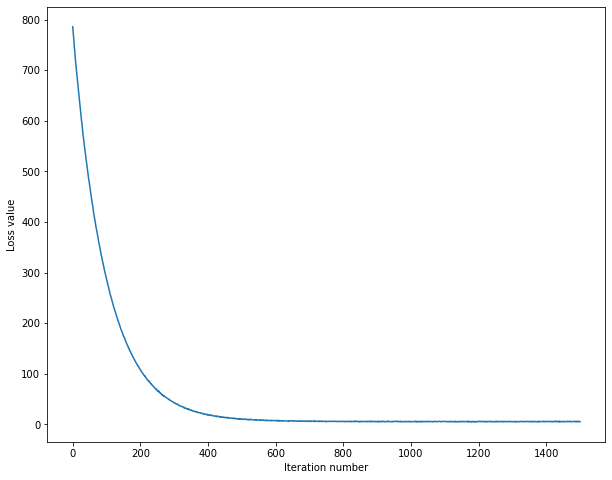

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370776
validation accuracy: 0.387000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-6]
regularization_strengths = [5e4, 1e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 788.327810
iteration 100 / 1500: loss 288.128721
iteration 200 / 1500: loss 108.186898
iteration 300 / 1500: loss 42.181389
iteration 400 / 1500: loss 18.548264
iteration 500 / 1500: loss 10.445594
iteration 600 / 1500: loss 7.021208
iteration 700 / 1500: loss 6.493496
iteration 800 / 1500: loss 5.549642
iteration 900 / 1500: loss 5.479789
iteration 1000 / 1500: loss 5.654754
iteration 1100 / 1500: loss 5.126325
iteration 1200 / 1500: loss 5.157620
iteration 1300 / 1500: loss 5.408666
iteration 1400 / 1500: loss 5.254486
iteration 0 / 1500: loss 1583.067977
iteration 100 / 1500: loss 214.337822
iteration 200 / 1500: loss 33.606462
iteration 300 / 1500: loss 9.517561
iteration 400 / 1500: loss 5.677480
iteration 500 / 1500: loss 5.402290
iteration 600 / 1500: loss 5.834237
iteration 700 / 1500: loss 5.768585
iteration 800 / 1500: loss 5.892429
iteration 900 / 1500: loss 5.699570
iteration 1000 / 1500: loss 6.073199
iteration 1100 / 1500: loss 5.760114
iteration 

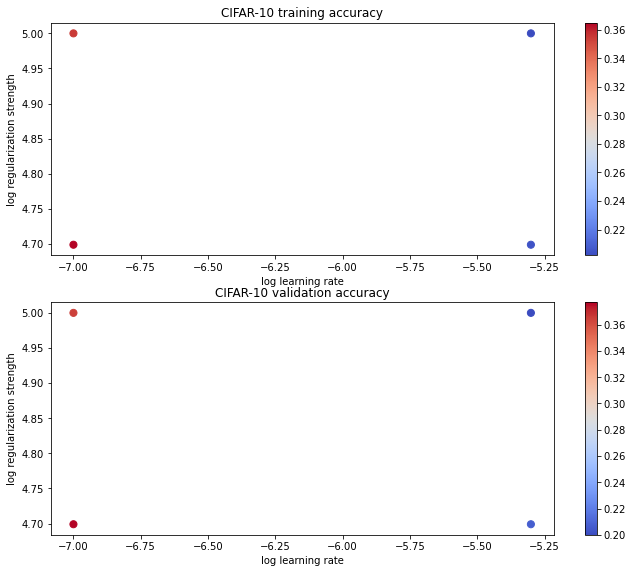

In [15]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 50
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.360000


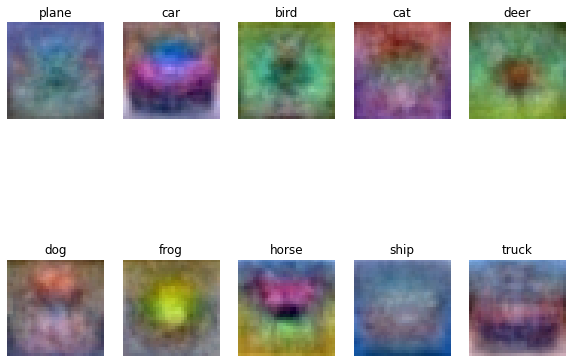

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
# print(w.shape)
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
#     plt.imshow(w[:, :, :, i].astype('uint8'))
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/linear_svm.py', 'cs231n/classifiers/linear_classifier.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))